In [1]:
!pip install -Uqq fastai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.6 MB/s eta 0:00:00


In [2]:
!pip install duckduckgo-search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 40.6 MB/s eta 0:00:00


In [3]:
!pip install fastdownload

In [4]:
from fastai.vision.all import *
from duckduckgo_search import DDGS

def search_images(keyword, max_images=200):
  return L(DDGS().images(keyword, max_results=max_images)).itemgot('image')

In [5]:
from fastdownload import download_url

hot_female = search_images('beautiful girl image', max_images=1)
dest = 'beautiful_girl.jpg'

download_url(hot_female[0], dest, show_progress=False)

Path('beautiful_girl.jpg')

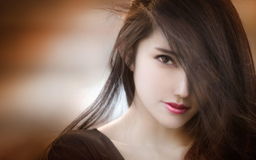

In [6]:
img = Image.open(dest)
img.to_thumb(256,256)

In [7]:
searches = 'beautiful', 'ugly'
path = Path('girls')

if not path.exists():
  path.mkdir()
  for o in searches:
    dest = (path/o)
    dest.mkdir(parents=True, exist_ok=True)
    results = search_images(f'{o} girls image', max_images=200)
    download_images(dest, urls=results)

In [8]:
len(get_image_files(path))

367

In [9]:
failed_images = verify_images(get_image_files(path))
len(failed_images)

12

In [10]:
failed_images.map(Path.unlink)

(#12) [None,None,None,None,None,None,None,None,None,None,None,None]

In [11]:
girl = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items = get_image_files,
                 splitter = RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=parent_label,
                 item_tfms=RandomResizedCrop(224, min_scale=0.4), batch_tfms=aug_transforms)

In [12]:
dls = girl.dataloaders(path)

In [13]:
learn = vision_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp

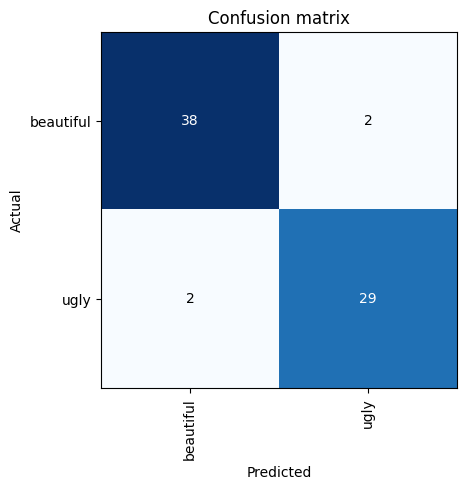

In [15]:
interp.plot_confusion_matrix()

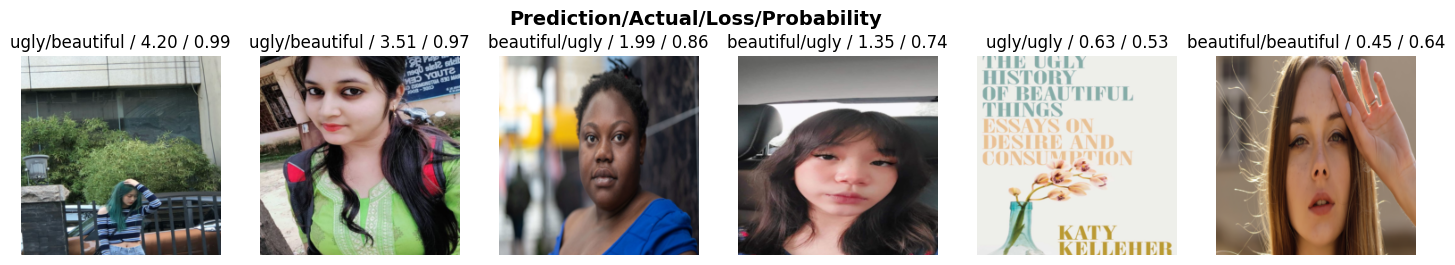

In [16]:
interp.plot_top_losses(6, nrows=1)

In [17]:
from fastai.vision.widgets import *

cleaner = ImageClassifierCleaner(learn)

In [18]:
cleaner

In [19]:
learn.export()

In [20]:
path = Path('')
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [21]:
learn_inf = load_learner(path/'export.pkl')

In [22]:
learn_inf.predict(img)

('beautiful', tensor(0), tensor([9.9998e-01, 2.1675e-05]))

In [23]:
learn_inf.dls.vocab

['beautiful', 'ugly']

In [24]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [25]:
out_pl = widgets.Output()
out_pl.clear_output()

In [26]:
with out_pl:
  display(img.to_thumb(128,128))

In [27]:
out_pl

Output()

In [29]:
pred,pred_idx,prob = learn_inf.predict(img)

In [43]:
lbl_pred = widgets.Label()
lbl_pred.value = f'PREDICTION: {pred},   PROBABILITY: {prob[pred_idx]: .4f}'
lbl_pred

Label(value='PREDICTION: beautiful,   PROBABILITY:  1.0000')

In [44]:
btn_run = widgets.Button(description = 'Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [45]:
def classify_on_click(change):
  img = PILImage.create(btn_upload.data[-1])
  with out_pl: display(img.to_thumb(128,128))
  pred,pred_idx,prob = learn_inf.predict(img)
  lbl_pred.value = f'PREDICTION: {pred} , PROBABILITY: {prob[pred_idx]: .4f}'

btn_run.on_click(classify_on_click)

In [46]:
VBox([widgets.Label('Select your Lady'),
      btn_upload, btn_run, out_pl, lbl_pred])